import libraries and load the data

In [3]:
# get the data 
! git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.


In [4]:
!ls pubmed-rct/

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [5]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [6]:
import os 
for path,dir,files in os.walk("pubmed-rct/"):
  if path.startswith('pubmed-rct/.git'):
    pass
  else:
     print(f"there is {len(dir)} dirs  and {len(files)} files in {path}")

there is 5 dirs  and 1 files in pubmed-rct/
there is 0 dirs  and 3 files in pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign
there is 0 dirs  and 3 files in pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign
there is 0 dirs  and 3 files in pubmed-rct/PubMed_200k_RCT
there is 0 dirs  and 3 files in pubmed-rct/PubMed_20k_RCT


In [7]:
for i in os.listdir("pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"):
 print("pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/" + i)

pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt
pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt
pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt


In [8]:
with open("pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt", "r") as f:
  test = f.readlines()

In [9]:
test[1:5]

['BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n']

In [10]:
test[1].split("\t")

['BACKGROUND',
 'This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n']

create function to preprocess the dataset

In [11]:
def create_target_text_dict(file):
  with open(f"pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/{file}.txt", "r") as f:
    data = f.readlines()
  abstract_lines = ""
  abstract_sample = []
  for line in data:
    if line.startswith("###"):
      abstract_lines = "" #new abstract 
      abstract_id = line
    elif line == "\n":
      for number,lin in enumerate(abstract_lines.splitlines()):
        abstract_dict = {}
        abstract_dict["line_number"] = number
        abstract_dict["target"] = lin.split("\t")[0]
        abstract_dict["text"] = lin.split("\t")[1]
      
        abstract_dict["total_lines"] = len(abstract_lines.splitlines())
        abstract_sample.append(abstract_dict)


    else:
      abstract_lines = abstract_lines + line
    
  return abstract_sample

In [12]:
train = create_target_text_dict("train")
test = create_target_text_dict("test")
valid = create_target_text_dict("dev")

convert to data frames with pandas

In [13]:
import pandas as pd
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
valid_df = pd.DataFrame(valid)

In [15]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,12
1,1,METHODS,A total of @ patients with primary knee OA wer...,12
2,2,METHODS,Outcome measures included pain reduction and i...,12
3,3,METHODS,Pain was assessed using the visual analog pain...,12
4,4,METHODS,Secondary outcome measures included the Wester...,12


In [16]:
train_df.describe(include="all")

,line_number,target,text,total_lines
count,180040.000000,180040,180040,180040.000000
unique,NaN,5,176946,NaN
top,NaN,METHODS,clinicaltrials.gov Identifier : NCT@ .,NaN
freq,NaN,59353,186,NaN
mean,5.894568,NaN,NaN,12.789136
std,4.127672,NaN,NaN,3.236095
min,0.000000,NaN,NaN,4.000000
25%,3.000000,NaN,NaN,11.000000
50%,6.000000,NaN,NaN,12.000000
75%,9.000000,NaN,NaN,15.000000


In [17]:
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

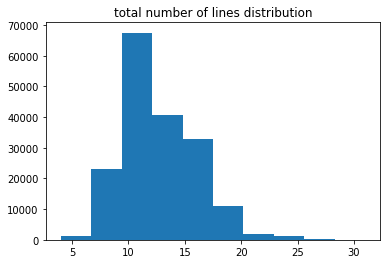

In [18]:
import matplotlib.pyplot as plt
plt.hist(train_df.total_lines)
plt.title("total number of lines distribution")
plt.show()

## model_0 baseline

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import numpy as np  

In [20]:
model_0 = Pipeline([
    ("embeding", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

encoding labels

In [21]:
le = LabelEncoder()
labels_encoded = le.fit_transform(np.array(train_df["target"]) )
le.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [22]:
model_0.fit(train_df["text"].to_numpy(), labels_encoded)

Pipeline(steps=[('embeding', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
train_score = model_0.score(train_df["text"],labels_encoded)
valid_score = model_0.score(valid_df["text"],le.transform(valid_df["target"]))
test_score  = model_0.score(test_df["text"],le.transform(test_df["target"]))

In [26]:
models_list = []
score_dict = {"Train Accuracy": train_score, "Validition Accuracy":valid_score, "Test Accuracy": test_score}
model_0 = pd.DataFrame(score_dict , index=["Model_0"])

In [28]:
models_list.append(model_0)

In [29]:
models_list[0]

,Train Accuracy,Validition Accuracy,Test Accuracy
Model_0,0.751683,0.721832,0.716675


## preparing for deep Sequence models

In [31]:
# how many words in avarage in every sensence?
sentence_len_list = [len(words.split()) for words in train_df["text"]]
np.mean(sentence_len_list)

26.338269273494777

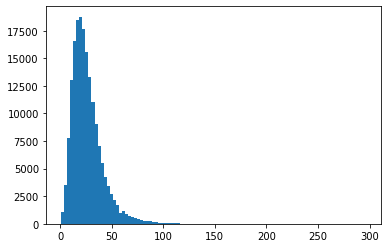

In [34]:
plt.hist(sentence_len_list, bins=100)
plt.show()

In [37]:
output_len = np.quantile(sentence_len_list, q=0.95)
output_len

55.0

In [38]:
max(sentence_len_list)

296

creating text vectorizer

In [43]:
max_tokens = 68000

In [41]:
import tensorflow as tf

In [45]:
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length= int(output_len ) 
)

In [46]:
text_vectorizer.adapt(train_df["text"])

In [51]:
import random
sent = random.choice(train_df["text"])
print(f"""
Sentence length : {len(sent.split())}
Sentence : {sent}
Sentence Vector : {text_vectorizer([sent])}
Vector length : {len(text_vectorizer([sent])[0])}
""")


Sentence length : 44
Sentence : This was accompanied by a slight decrease in percentage of time in the target range of @-@ mmol/L ( @ vs. @ % ) and increase in mean BG ( @ vs. @ mmol/L ; P = @ ) on CLC versus OL .
Sentence Vector : [[   23    10  2774    22     8  3837   318     5   467     4    63     5
      2   492   283     4   860    44     3   179     5    57  6314    44
    860    14    18  9460   110 10636     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Vector length : 55
Vector length not 0 : 55




In [57]:
print(f"{len(text_vectorizer.get_vocabulary())}\n Most common words : {  text_vectorizer.get_vocabulary()[:20]} \n least common words {  text_vectorizer.get_vocabulary()[-20:]}")

64841
 Most common words : ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were', 'was', 'for', 'patients', 'group', 'p', 'at', 'or', 'study', 'on', 'treatment'] 
 least common words ['abandon', 'abaloparatideinduced', 'abagovomabinduced', 'abacus', 'abacopd', 'abacavirlamivudinezidovudine', 'ababa', 'aavsercaa', 'aats', 'aartselaar', 'aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [60]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None, None),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

create custom text embediing

In [122]:
embeding = tf.keras.layers.Embedding(len(text_vectorizer.get_vocabulary()),128, mask_zero = True, name = "token_embedings")        

In [64]:
sent = random.choice(train_df["text"])
print(f"""
Sentence length : {len(sent.split())}
Sentence : {sent}
Sentence emmbedings : {embeding(text_vectorizer([sent]))}
shape : {embeding(text_vectorizer([sent])).shape}
""")


Sentence length : 60
Sentence : The mean ejection fraction was @ % ( range -LSB- R -RSB- , @-@ ) , the mean age was @ years ( R , @-@ ) , @ % ( @/@ ) were men , @ % ( @/@ ) underwent previous coronary artery bypass grafting surgery , and @ % ( @/@ ) underwent prior coronary stenting .
Sentence emmbedings : [[[-0.019207   -0.00338825  0.00843153 ... -0.00944455 -0.02219868
    0.04154963]
  [ 0.02145697  0.03437359 -0.04842908 ... -0.00900956 -0.01541126
   -0.01395201]
  [ 0.03210843  0.01176965 -0.03374273 ... -0.01839361 -0.01396872
    0.01722017]
  ...
  [-0.00458183  0.01713834  0.00727938 ... -0.01627716 -0.01597232
    0.0167431 ]
  [-0.00458183  0.01713834  0.00727938 ... -0.01627716 -0.01597232
    0.0167431 ]
  [-0.00458183  0.01713834  0.00727938 ... -0.01627716 -0.01597232
    0.0167431 ]]]
shape : (1, 55, 128)



Creating tensorflow datasets to load faster

In [96]:
one_hot =  OneHotEncoder(sparse= False)
train_labels = one_hot.fit_transform(np.reshape(np.array(train_df["target"] ) , (-1,1)))
test_labels = one_hot.transform(np.reshape(np.array(test_df["target"]), (-1,1)))
valid_labels = one_hot.transform(np.reshape(np.array(valid_df["target"]), (-1,1)))


In [89]:
np.array(train_df["target"])

array(['OBJECTIVE', 'METHODS', 'METHODS', ..., 'RESULTS', 'CONCLUSIONS',
       'CONCLUSIONS'], dtype=object)

maping - cachining - shuffeling - batching - prefetching 

In [97]:
train = tf.data.Dataset.from_tensor_slices((train_df["text"], train_labels))
test = tf.data.Dataset.from_tensor_slices((test_df["text"], test_labels))
valid = tf.data.Dataset.from_tensor_slices((valid_df["text"], valid_labels))

In [98]:
train = train.batch(32).prefetch(tf.data.AUTOTUNE)
test = test.batch(32).prefetch(tf.data.AUTOTUNE)
valid = valid.batch(32).prefetch(tf.data.AUTOTUNE)

In [104]:
list(valid.as_numpy_iterator())[0][1].shape

(32, 5)

In [118]:
valid

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model1 : Conv1D

In [105]:
from tensorflow.keras import layers

In [126]:
input = layers.Input((1,), dtype= tf.string)
text_vectors = text_vectorizer(input)
embed = embeding(text_vectors)
x = layers.Conv1D(filters = 64, kernel_size = 5 , padding = "same", activation= "relu") (embed)
x = layers.GlobalAveragePooling1D() (x)
output = layers.Dense(5, activation="softmax") (x)

model1 = tf.keras.models.Model(input, output)

In [127]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedings (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_3 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense (Dense)               (None, 5)                 325   

In [128]:
model1.compile(
    loss = "categorical_crossentropy",
    optimizer= "adam",
    metrics = "accuracy"
)

In [134]:
def checkpoint(model_name):
  return tf.keras.callbacks.ModelCheckpoint(("Experiments"+ model_name),save_best_only=True )

In [136]:
history = model1.fit(train, 
                     epochs = 5,
                     validation_data = valid,
                     callbacks = [checkpoint("conv1d")])

Epoch 1/5
5627/5627 [==============================] - ETA: 0s - loss: 0.6155 - accuracy: 0.7755

5627/5627 [==============================] - 599s 106ms/step - loss: 0.6155 - accuracy: 0.7755 - val_loss: 0.5353 - val_accuracy: 0.8097
Epoch 2/5
5627/5627 [==============================] - ETA: 0s - loss: 0.4526 - accuracy: 0.8416

5627/5627 [==============================] - 600s 107ms/step - loss: 0.4526 - accuracy: 0.8416 - val_loss: 0.5330 - val_accuracy: 0.8102
Epoch 3/5
5627/5627 [==============================] - 606s 108ms/step - loss: 0.3724 - accuracy: 0.8724 - val_loss: 0.5654 - val_accuracy: 0.8073
Epoch 4/5
5627/5627 [==============================] - 600s 107ms/step - loss: 0.3082 - accuracy: 0.8973 - val_loss: 0.6243 - val_accuracy: 0.8008
Epoch 5/5
5627/5627 [==============================] - 596s 106ms/step - loss: 0.2543 - accuracy: 0.9178 - val_loss: 0.7014 - val_accuracy: 0.7936


In [137]:
model1.evaluate(test)

942/942 [==============================] - 13s 13ms/step - loss: 0.7249 - accuracy: 0.7870


[0.7248784303665161, 0.7869586944580078]

## Model2 : with pretrained embeding layer

In [138]:
import tensorflow_hub as hub

In [140]:
use_embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable = False)

In [143]:
sent = random.choice(train_df["text"])
print(f"""
Sentence length : {len(sent.split())}
Sentence : {sent}
shape : {use_embed([sent]).shape}
""")


Sentence length : 18
Sentence : Bioequivalence is the most appropriate procedure to evaluate the quality and therapeutic efficacy of a generic product .
shape : (1, 512)



In [144]:
input = layers.Input([], dtype= tf.string)
embed = use_embed(input)
x = layers.Dense(128, activation= "relu") (embed)
output = layers.Dense(5, activation="softmax") (x)

model2 = tf.keras.models.Model(input, output)

In [151]:
model2.compile(
    loss = "categorical_crossentropy",
    optimizer= "adam",
    metrics = "accuracy"
)

In [146]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [152]:
history2 = model2.fit(train, 
                     epochs = 5,
                      steps_per_epoch= 0.1*len(train),
                     validation_data = valid,
                      validation_steps = 0.1*len(valid),
                     callbacks = [checkpoint("Dense")])

Epoch 1/5
562/562 [==============================] - 22s 35ms/step - loss: 0.9175 - accuracy: 0.6490 - val_loss: 0.8025 - val_accuracy: 0.6885
Epoch 2/5
562/562 [==============================] - 23s 41ms/step - loss: 0.7684 - accuracy: 0.7007 - val_loss: 0.7560 - val_accuracy: 0.7072
Epoch 3/5
562/562 [==============================] - 18s 32ms/step - loss: 0.7496 - accuracy: 0.7138 - val_loss: 0.7384 - val_accuracy: 0.7122
Epoch 4/5
562/562 [==============================] - 19s 34ms/step - loss: 0.7176 - accuracy: 0.7241 - val_loss: 0.7104 - val_accuracy: 0.7319
Epoch 5/5
562/562 [==============================] - 19s 34ms/step - loss: 0.7242 - accuracy: 0.7221 - val_loss: 0.6925 - val_accuracy: 0.7342


In [153]:
model2.evaluate(test)

942/942 [==============================] - 12s 13ms/step - loss: 0.7137 - accuracy: 0.7271


[0.7136521339416504, 0.7271279096603394]

## Model3 : with charachter embeding